# [`XLA.jl`](https://github.com/JuliaTPU/XLA.jl): ResNet on TPUs - Training

In this notebook, we will build on [the previous notebook](1_ResNet_Intro.ipynb) by introducing the training loop on TPUs for the ResNet 50 computer vision model.  We will use the same model, this time embedding its forward pass within a loop that streams batches of data in through an XLA InFeed and streams training loss out through an XLA OutFeed.  We essentially build an autonomous program which accepts tensors fed in over the network, calculates forward pass, backward pass, updates the model, and then finally returns the fully trained model.  This means that once the TPU code is running, it runs until the model is fully trained, the only interaction required with the TPU is feeding in data.

For simplicity and speed, we make use of a preprocessed ImageNet dataset, where each image has been transformed into a `224x224x3` array of UInt8's and each label has been transformed into a `UInt16`, which are stored on disk.  The image preprocessing steps can be found in [this notebook](PreprocessedImagenet.ipynb), for the terminally curious.  These are transferred to the TPU, where they are then unpacked and normalized into `Float32` tensors, ready to be run through the Flux model.

In [1]:
# Load package versions that are known to work with TPUs, check that Julia version is a known compatible one
if Base.GIT_VERSION_INFO.commit != "95310a080bffd5cc0d5708f3356998ad521303ff"
    @warn("Only the very latest Julia version on the `kf/tpu3` branch is supported!")
end

import Pkg
if haskey(ENV, "COLAB_GPU")
    # On colab instantiate from the installed version of XLA.jl
    Pkg.activate("/content/XLA.jl/examples")
else
    # In a checked out copy, this notebook is in the examples directory
    Pkg.activate(@__DIR__)
end
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
# Load in packages and model definition
using TensorFlow, XLA, Flux, Zygote, Printf
include("resnet50.jl")
include("preprocessing_utils.jl")
include("model_utils.jl")

model = resnet50();
println("=> Initialized ResNet50 model with $(sum(prod(size(p)) for p in params(model))) learnable parameters")

# Convert our model to the TPU-compatible version
tpu_model = map_to_tpu(model)
println("=> Mapped model to TPU-specific construction")

┌ Info: Recompiling stale cache file /home/sabae/.julia/compiled/v1.1/XLA/bZBiw.ji for XLA [1ae4bca4-de81-11e8-0eca-6d3e4e7c4181]
└ @ Base loading.jl:1184
┌ Warning: Package XLA does not have Random in its dependencies:
│ - If you have XLA checked out for development and have
│   added Random as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with XLA
└ Loading Random into XLA from project dependency, future warnings for XLA are suppressed.


=> Initialized ResNet50 model with 25583464 learnable parameters
=> Mapped model to TPU-specific construction


## The Training Loop

We will define here a training loop that will run as a program on the TPU, taking batches in through an infeed, calculating forward and backward passes, updating weights, and outputting training loss through an outfeed.  We make use of [`Zygote.jl`](https://github.com/FluxML/Zygote.jl) to automatically differentiate the model, generating a function that calculates the backward pass and applying the updates using a custom-built `SGD` implementation.

First, getting data onto the device.  TPUs do not support UInt8 arrays at the time of writing, so we pack a single pixel's (R, G, B) values into a UInt32, and transfer tensors of UInt32's across the wire to the TPU.  See [`preprocessing_utils.jl`](preprocessing_utils.jl) for more on that.  We define a method called `getminibatch_data()` that will read from an infeed, convert the pixel-packed values to `Float32` tensors ready for pushing through the model, and expanding the provided labels into onehot matrices.  Note that the `Val{batch_size}` is because we need this method to be completely statically inferrable (including the size of all tensors).  We pass in `batch_size` as a value type parameter to support compiling models for different batch sizes easily, whereas spatial resolution (`224x224` in this case) is hardcoded as that is much less likely to change, however the same treatment could be given to those values to create a more general infeed function.

In [3]:
function get_minibatch_data(::Val{batch_size}) where {batch_size}
    # Construct HloInfeed object that will expect to receive a tuple
    # of two arrays, one for `x` and one for `y`.  Note that incorrect sizes
    # here will cause...unexpected results, so do your best not to do that.
    # We feed data in as 1-dimensional UInt32 arrays, then reshape them.
    infeed = XLA.HloInfeed(Tuple{
        XRTArray{UInt32, (224*224*batch_size,), 1},
        XRTArray{UInt32, (batch_size,), 1},
    })

    # Read in from the infeed
    (x, y), _ = infeed(XLA.HloAfterAll()())
    x = reshape(x, (224, 224, batch_size))
    
    # Do pixel unpacking/channel normalization.
    x = unpack_pixels(x)

    # Convert labels to (dense) onehot representation
    y = make_onehot(y)
    #y = convert(XRTArray{Float32}, Flux.OneHotMatrix(1000, convert(XRTArray{Int64}, y)))
    
    # Return our data!
    return x, y
end

get_minibatch_data (generic function with 1 method)

Next up, optimizer definition.  We hand-craft a simple SGD implementation here; for a more advanced optimizer (ADAM) see the [`tpu_optimizers.jl`](tpu_optimizers.jl) file which contains this SGD implementation as well.  `ADAM` is slightly more complex as it must track gradient statistics for each weight in the model, complicating the update step, however we use it in future tutorials as it attains significantly better performance in large models.  In this example, we simply define an `SGD` type for dispatch purposes, then define a recursive update rule that will walk the model weights and gradients, updating as it goes and returning a new model:

In [4]:
struct SGD
    # Learning rate; the only data this optimizer needs to bundle with itself
    η::XRTArray{Float32,(),0}
end

# Simplest update step in existence.
update!(model::XRTArray, Δ::XRTArray, η) = model - (Δ .* η)

# If this leaf node had no updates calculated for it, then skip out early.
update!(model, Δ::Nothing, η) = model

function update!(model, Δ, η)
    # Base condition; if we have reached a leaf node return the inputs unchanged.
    # Note that if `model` is an XRTArray, we will hit the override above that actually
    # updates the model rather than this generic update!(), same for if Δ is `nothing`.
    if nfields(model) == 0
        return model
    end
    
    # Recursively pass the fields of this model through the update machinery.  We use
    # this strange ntuple() do-block because we cannot perform any kind of mutation
    # (such as push!()'ing onto a list) and so we adopt this more functional-style of
    # programming.
    new_fields = ntuple(Val(nfields(model))) do i
        return update!(getfield(model, i), getfield(Δ, i), η)
    end
    
    # Return something of the same type as `model`, but with the new fields
    if isa(model, Tuple)
        return new_fields
    else
        return typeof(model)(new_fields...)
    end
end

# Main entry point for this optimizer's update steps
update!(opt::SGD, model, Δ) = update!(model, Δ, opt.η)

update! (generic function with 4 methods)

Finally, the full training loop.  Now that we have the above pieces, this is conceptually very simple.  We will first initialize our optimizer object (not much to do there for SGD, but once we start using ADAM, this will become a little more involved), then we enter the minibatch-processing loop.  This loop will infeed a new batch of data, push it through the model calculating loss, then backpropagate, minimizing that loss in order to calculate a set of updates that should be applied to the model.  We then apply those updates to the model, finally outputting the training loss for this minibatch back to the controlling host.  Finally, once we have exceeded `nbatches` of training data, we return the trained model.

In [5]:
# Define our training loop
function train_loop(::Val{batch_size}, model, nbatches, η) where {batch_size}
    # Initialize optimizer, will allocate space for all necessary statistics within itself
    opt = SGD(η)

    # Run until nbatches is zero
    while nbatches > XRTArray(0)
        # Get next minibatch of data
        mb_data = get_minibatch_data(Val(batch_size))

        # Let block to fend off the inference demons
        loss, back = let x = mb_data[1], y = mb_data[2]
            # Calculate forward pass to get loss, and compile backwards pass
            # to get the updates to our model weights.
            Zygote._forward(
                Zygote.Context{Nothing}(nothing),
                model -> logitcrossentropy(model(x), y),
                model,
            )
        end

        # Evaluate the backwards pass.  Zygote automatically calculates
        # sensitivities upon `x` and `y`; we discard those via the tail()
        Δ_model = Zygote.tailmemaybe(back(1f0))[1]

        # Update parameters via our optimizer
        model = update!(opt, model, Δ_model)

        # Outfeed the loss
        loss = reshape(loss, (1,))
        XLA.HloOutfeed()((loss,), XLA.HloAfterAll()())

        # Count down the batches
        nbatches -= XRTArray(1)
    end
    
    # At the end of all things, return the trained model
    return model
end

train_loop (generic function with 1 method)

## Running the training loop

Now that we've got all that code written up, let's actually run the training loop.  First, we compile it.  Again, this can take a _very_ long time (on the GCE instance this notebook was run on, this took over 200 seconds), so be patient.

In [13]:
# Manually initialize if we're not running in colab
if !haskey(ENV, "COLAB_TPU_ADDR")
    tpu_ip = "10.240.48.2"
    println("Connecting to TPU on $(tpu_ip)")
    XLA.initialize!("$(tpu_ip):8470"; reset=true)
end

# Train in batch sizes of 128, for 10000 batches with a learning rate of 1e-2
batch_size = 128
num_batches = 10000
η = 0.01f0

# We need to work around a TensorFlow bug which doesn't choose the default infeed/outfeed
# device placement properly.  We do so by explicitly placing all operations on the first TPU core
sess = XLA.global_session()
tpu_device = first(all_tpu_devices(sess))

# Compile the model
t_start = time()
compilation_handle = @tpu_compile devices=[tpu_device] train_loop(Val(batch_size), tpu_model, XRTArray(num_batches), XRTArray(η));
t_end = time()

println(@sprintf("=> Compiled training loop in %.1f seconds", t_end - t_start))

Connecting to TPU on 10.240.25.3
=> Compiled training loop in 48.9 seconds


2019-02-25 16:42:31.791819: W tensorflow/core/distributed_runtime/rpc/grpc_session.cc:349] GrpcSession::ListDevices will initialize the session with an empty graph and other defaults because the session has not yet been created.


This loop is an asynchronous program that will block on the TPU waiting for input from us, so we will launch it on a separate Julia coroutine by using the `@async` macro when invoking `run()`, then after launching it start sending data to the TPU through the infeed and reading output back from the outfeed.

In [14]:
# Explicitly place each argument of our compilation onto the first tpu_device
compilation_args = with_device(XLA.tf_tpu_device(sess, tpu_device)) do
    return (
        XRTRemoteStruct(sess, tpu_model),
        XRTArray(sess, num_batches),
        XRTArray(sess, η)
    )
end

# Launch a task to run our training loop
loop_task = @async run(compilation_handle, compilation_args...; device=tpu_device)

Task (runnable) @0x00007f6ab4e3c280

Let's make sure that the loop task is actually running (if there is an error on the TPU, it will fail).

In [15]:
loop_task

Task (runnable) @0x00007f6ab4e3c280

At this point, there is a program running on the TPU that is blocked on input, and so the next step is to provide that input.

## Feeding the training loop

We will load in data from our preprocessed training set, saved as raw tensors on disk that we can directly memmap in.  Because the data rates that we want to feed our network with often exceed the rate that we can read in from disk, we recommend paying for a large enough instance to fit the entire dataset into RAM, and using a tool such as [`vmtouch`](https://github.com/hoytech/vmtouch) to preload it.  It's important to shuffle your data, so we build a permutation vector to read in with a randomized ordering across images, which works well in conjunction with the aforementioned `vmtouch` to preload your dataset into RAM.

In [16]:
using Mmap, Random, Statistics

# memmap our dataset of 1.2M images in as giant, raw tensors.
num_images = 1281167
Xs = Mmap.mmap("/home/sabae/ILSVRC/224/X_train.raw", Array{UInt8,4}, (224, 224, 3, num_images))
Ys = Mmap.mmap("/home/sabae/ILSVRC/224/Y_train.raw", Array{UInt16,1}, (num_images,))
permutation = Random.shuffle(1:num_images);

We next convert slices of data into the one-dimensional `UInt32` arrays that our model expects, and we send them over the wire with tensorflow infeeds and outfeeds.  The TensorFlow-dictated boilerplate here is large, due to needing to create placeholders, that are hooked up to feeds, then create dictionaries mapping tensors to fit into those placeholders to be sent to those feeds, but eventually we intend to simplify this greatly.

In [17]:
# We create ops to push data in and pull data out of the TPU
function make_placeholder(sess, device, len)
    return with_device(XLA.tf_host_cpu_device(sess, device)) do
        return XLA.placeholder(UInt32, shape=(len,))
    end
end

x_size = 224*224*batch_size
y_size = batch_size
x_placeholder = make_placeholder(sess, tpu_device, x_size)
y_placeholder = make_placeholder(sess, tpu_device, y_size)

infeed_op = XLA.make_infeed_on(sess,
    # Make the infeed on this device
    tpu_device,
    
    # It feeds in these element types
    (UInt32, UInt32),
    
    # With these sizes
    ((x_size,),(y_size,)),
    
    # And is associated with these TF placeholders
    [x_placeholder, y_placeholder],
)

# Also make an outfeed op
outfeed_op = XLA.make_outfeed_on(sess,
    # On this device
    tpu_device,
    
    # Which will output this type
    Tuple{XRTArray{Float32, (), 0},}
)

# For each minibatch
losses = Float64[]
for batch_idx in 1:num_batches
    batch_slice = permutation[((batch_idx - 1)*batch_size + 1):batch_idx*batch_size]

    # Convert the next minibatch of data into our UInt32 vectors:
    x_batch = pixel_pack(Xs[:, :, :, batch_slice])
    y_batch = UInt32.(Ys[batch_slice])

    # Send our tensors in to the predefined placeholders
    infeed_dict = Dict(
        x_placeholder => vec(x_batch),
        y_placeholder => vec(y_batch),
    )
    run(sess, infeed_op, infeed_dict)
    
    # Get loss back
    loss = run(sess, outfeed_op)
    push!(losses, loss)

    # Print it out as we go, showing the average loss to (hopefully) watch it decrease
    if batch_idx % 100 == 0
        println("[$batch_idx] loss: $(loss) avg loss: $(mean(losses[max(end-50,1):end]))")
    end
end

[100] loss: 7.0092382 avg loss: 7.118526907528148
[200] loss: 7.0078382 avg loss: 6.992308887780881
[300] loss: 6.8505564 avg loss: 6.9212675468594425
[400] loss: 6.7608247 avg loss: 6.835668517094033
[500] loss: 6.7760644 avg loss: 6.749406122693829
[600] loss: 6.620154 avg loss: 6.657701221166873
[700] loss: 6.4857583 avg loss: 6.594551273420746
[800] loss: 6.382309 avg loss: 6.5499467195249075
[900] loss: 6.5751495 avg loss: 6.479092981301102
[1000] loss: 6.4222283 avg loss: 6.419285961225921
[1100] loss: 6.326692 avg loss: 6.362740881302777
[1200] loss: 6.353909 avg loss: 6.296905760671578
[1300] loss: 6.2066298 avg loss: 6.275549112581739
[1400] loss: 6.070703 avg loss: 6.194364052192838
[1500] loss: 5.9737945 avg loss: 6.124572351867077
[1600] loss: 6.257305 avg loss: 6.0860850670758415
[1700] loss: 6.0582695 avg loss: 6.034616404888677
[1800] loss: 6.0312686 avg loss: 5.965800855673995
[1900] loss: 5.7755704 avg loss: 5.892345811806473
[2000] loss: 5.7897 avg loss: 5.82899345136

## Visualizing training outputs

We can see the training loss over time by plotting the `losses` vector that we have been accumulating:

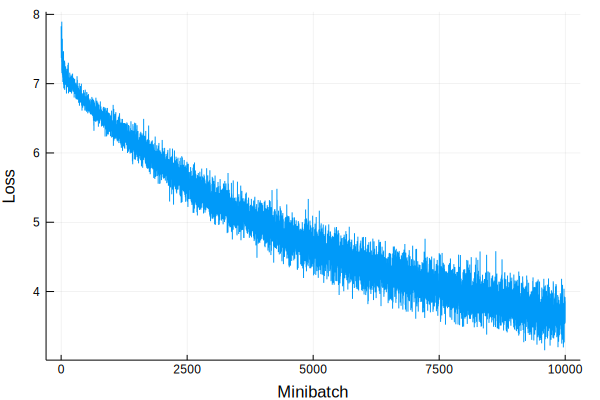

In [18]:
using Plots
Plots.plot(losses; xlabel="Minibatch", ylabel="Loss", legend=nothing)

We can furthermore inspect our trained model by looking at the return value of the training loop task; as we returned the trained `model` object, we can transfer that back to the host CPU through the `convert()` function call, and what we get back is an object of the same type that we sent to the TPU:

In [20]:
# Once it's done, we can fetch the result of the loop task to get back the trained model.
# It comes back as an opaque (parameterized) type, so we explicitly convert it to its proper type here.
ret = fetch(loop_task)
trained_model = convert(typeof(ret).parameters[1], ret);

# Show one example tensor to prove that we learned something, and that we got a tensor back
trained_model.layers[1].bias

64-element XRTArray{Float32,(64,),1}:
  5.135598e-6 
 -4.2456653e-5
  7.519108e-5 
  2.531462e-6 
  4.692167e-5 
 -4.9379983e-6
 -0.0001054188
  1.0703307e-5
 -5.793135e-5 
 -9.362626e-5 
 -3.265237e-5 
  4.474578e-5 
 -2.843049e-5 
  ⋮           
  3.02923e-5  
 -5.8644055e-5
 -6.992366e-5 
 -5.9106704e-5
 -6.048937e-5 
 -1.8271241e-5
  6.894357e-5 
  7.862924e-6 
 -6.1116836e-5
  1.563895e-5 
  3.052865e-5 
 -9.1876915e-5